In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
import joblib

#load preprocessed data 
base_path = '/Users/ceciliatorres/Desktop/Personal work/maintenance_risk/maintenance_risk/notebooks/processed_data/'
X_train = joblib.load(base_path + 'X_train.pkl')
X_test  = joblib.load(base_path + 'X_test.pkl')
y_train = joblib.load(base_path + 'y_train.pkl')
y_test  = joblib.load(base_path + 'y_test.pkl')


Definition of functions to standardise model evaluation: 

In [2]:
def evaluate_model(model, X_test, y_test, name="model"):
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n{name} — metrics")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

def plot_confusion(model, X_test, y_test, title="Confusion matrix"):
    cm = confusion_matrix(y_test, model.predict(X_test))
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    plt.tight_layout(); plt.show()


Now we train a Random Forest model to capture non-linear relationships and feature interactions:


RandomForest (baseline) — metrics
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       110
           1       0.89      0.92      0.91        79

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189

Confusion matrix:
 [[101   9]
 [  6  73]]
Accuracy: 0.921 | Precision: 0.890 | Recall: 0.924 | F1: 0.907 | ROC-AUC: 0.976


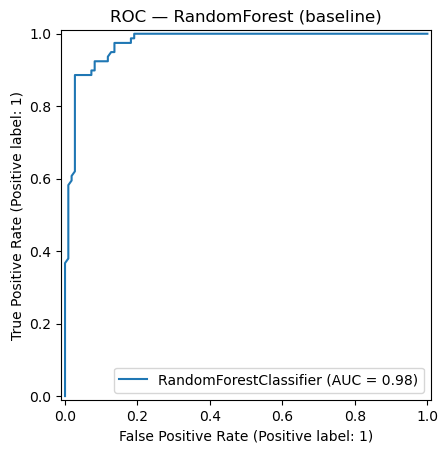

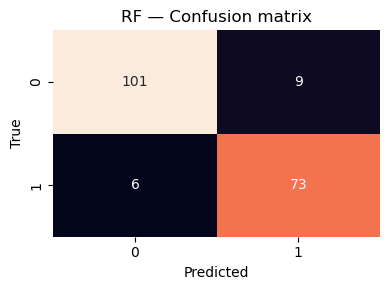

In [3]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

rf_metrics = evaluate_model(rf, X_test, y_test, name="RandomForest (baseline)")
RocCurveDisplay.from_estimator(rf, X_test, y_test); plt.title("ROC — RandomForest (baseline)"); plt.show()
plot_confusion(rf, X_test, y_test, "RF — Confusion matrix")


Now features importance: we examine which features contribute the most to the Random Forest’s predictions, helping us understand the key drivers of the model.

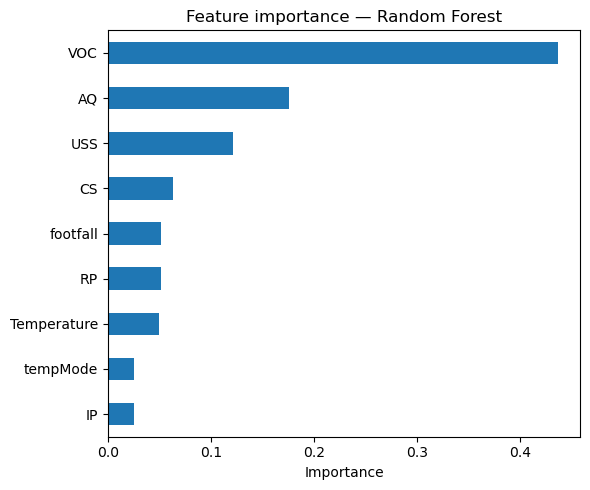

In [4]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()
ax = importances.plot(kind="barh", figsize=(6,5))
ax.set_title("Feature importance — Random Forest")
ax.set_xlabel("Importance"); plt.tight_layout(); plt.show()


Cross-validation: 

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
print("RF 5-fold ROC-AUC:", cv_scores, " | mean:", np.mean(cv_scores).round(4))


RF 5-fold ROC-AUC: [0.93380231 0.95761183 0.95643939 0.98665224 0.96966642]  | mean: 0.9608


Tuning: 

Best params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5} | CV AUC: 0.9629084625052368

RandomForest (tuned) — metrics
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       110
           1       0.85      0.95      0.90        79

    accuracy                           0.91       189
   macro avg       0.91      0.92      0.91       189
weighted avg       0.92      0.91      0.91       189

Confusion matrix:
 [[97 13]
 [ 4 75]]
Accuracy: 0.910 | Precision: 0.852 | Recall: 0.949 | F1: 0.898 | ROC-AUC: 0.979


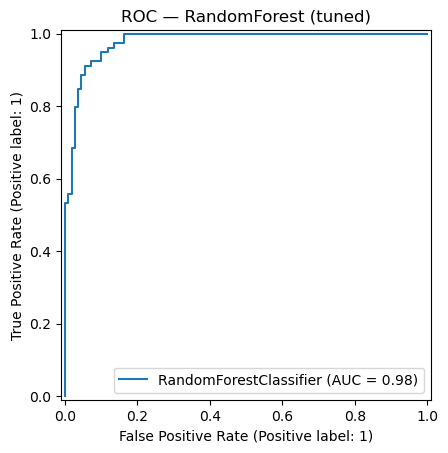

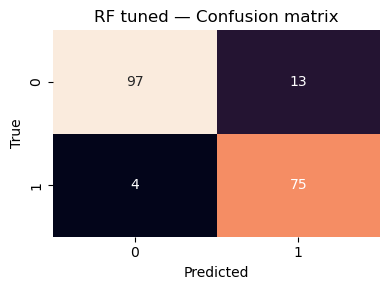

['/Users/ceciliatorres/Desktop/Personal work/maintenance_risk/maintenance_risk/notebooks/processed_data/rf_best.pkl']

In [7]:
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}
rf_base = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
rs = RandomizedSearchCV(
    rf_base, param_distributions=param_dist,
    n_iter=20, cv=5, scoring="roc_auc", n_jobs=-1, random_state=42, verbose=0
)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print("Best params:", rs.best_params_, "| CV AUC:", rs.best_score_)

best_metrics = evaluate_model(best_rf, X_test, y_test, name="RandomForest (tuned)")
RocCurveDisplay.from_estimator(best_rf, X_test, y_test); plt.title("ROC — RandomForest (tuned)"); plt.show()
plot_confusion(best_rf, X_test, y_test, "RF tuned — Confusion matrix")

#save the best model
joblib.dump(best_rf, base_path + 'rf_best.pkl')


Now we evaluate the Random Forest model and compare its performance to Logistic Regression to see if it brings noticeable improvements.

In [8]:
try:
    logit = joblib.load(base_path + 'logistic_model.pkl')
except:
    logit = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42).fit(X_train, y_train)

logit_metrics = evaluate_model(logit, X_test, y_test, name="LogisticRegression")

#we compare: 
comparison = pd.DataFrame([logit_metrics, rf_metrics, best_metrics])
display(comparison.sort_values("roc_auc", ascending=False))



LogisticRegression — metrics
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       110
           1       0.85      0.94      0.89        79

    accuracy                           0.90       189
   macro avg       0.90      0.91      0.90       189
weighted avg       0.91      0.90      0.91       189

Confusion matrix:
 [[97 13]
 [ 5 74]]
Accuracy: 0.905 | Precision: 0.851 | Recall: 0.937 | F1: 0.892 | ROC-AUC: 0.965


,model,accuracy,precision,recall,f1,roc_auc
2,RandomForest (tuned),0.910053,0.852273,0.949367,0.898204,0.978596
1,RandomForest (baseline),0.920635,0.890244,0.924051,0.906832,0.975949
0,LogisticRegression,0.904762,0.850575,0.936709,0.891566,0.965132


Now we train a XGBoost model: 


XGBoost — metrics
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       110
           1       0.88      0.90      0.89        79

    accuracy                           0.90       189
   macro avg       0.90      0.90      0.90       189
weighted avg       0.91      0.90      0.90       189

Confusion matrix:
 [[100  10]
 [  8  71]]
Accuracy: 0.905 | Precision: 0.877 | Recall: 0.899 | F1: 0.887 | ROC-AUC: 0.966


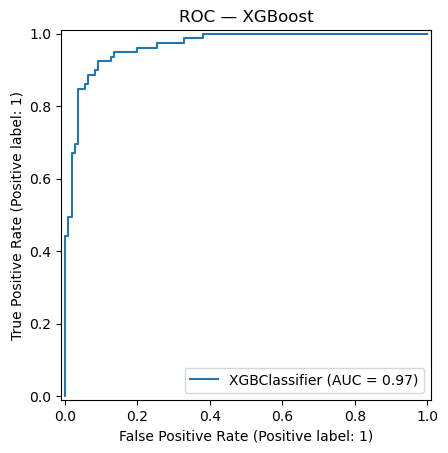

In [10]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8,
    eval_metric="auc", random_state=42, n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_metrics = evaluate_model(xgb, X_test, y_test, name="XGBoost")
RocCurveDisplay.from_estimator(xgb, X_test, y_test); plt.title("ROC — XGBoost"); plt.show()


Now we compare Random Forest and XGBoost side by side to evaluate which model performs best across all metrics:

In [12]:
results_df = pd.DataFrame([rf_metrics, xgb_metrics])
display(results_df)

,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest (baseline),0.920635,0.890244,0.924051,0.906832,0.975949
1,XGBoost,0.904762,0.876543,0.898734,0.887500,0.966398


The Random Forest slightly outperforms XGBoost in most metrics, it may be the better choice for this dataset.

In [13]:
# 1️⃣ Créer une copie du jeu de test
df_export = X_test.copy()
df_export["true_label"] = y_test.values

# 2️⃣ Ajouter prédictions et probabilités RF
df_export["rf_pred"] = rf.predict(X_test)
df_export["rf_proba"] = rf.predict_proba(X_test)[:, 1]

# 3️⃣ Ajouter prédictions et probabilités XGB
df_export["xgb_pred"] = xgb.predict(X_test)
df_export["xgb_proba"] = xgb.predict_proba(X_test)[:, 1]

# 4️⃣ Sauvegarder en CSV
df_export.to_csv("model_predictions.csv", index=False)

print("✅ Fichier 'model_predictions.csv' créé — prêt pour Tableau !")


✅ Fichier 'model_predictions.csv' créé — prêt pour Tableau !


In [14]:
# RandomForest feature importances
rf_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

rf_importances.to_csv("rf_feature_importances.csv", index=False)
print("✅ 'rf_feature_importances.csv' créé.")

# XGBoost feature importances
xgb_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

xgb_importances.to_csv("xgb_feature_importances.csv", index=False)
print("✅ 'xgb_feature_importances.csv' créé.")


✅ 'rf_feature_importances.csv' créé.
✅ 'xgb_feature_importances.csv' créé.
